In [36]:
import h5py
import numpy as np
import matplotlib
import scipy
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import dedalus.public as d3
from dedalus.extras import plot_tools

import sys
sys.path.append("../../../dedalus_subroutines")
from isospectrum import isospectrum

In [37]:
snapname = '../QGNIW_snap/QGNIW_snap_s1.h5'
diagname = '../QGNIW_diag/QGNIW_diag_s1.h5'

with h5py.File(snapname, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (8 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_d59679baad5bbe977384d18cb73897d07a757e19', 'y_hash_d59679baad5bbe977384d18cb73897d07a757e19']
<HDF5 group "/tasks" (5 members)>
['PV', 'phii', 'phir', 'psi', 'wave_pressure']


In [38]:
# Plot writes
with h5py.File(snapname, mode='r') as file:
    
    psi_data = np.squeeze(np.array(file['tasks']['psi']))
    phir_data = np.squeeze(np.array(file['tasks']['phir']))
    phii_data = np.squeeze(np.array(file['tasks']['phii']))
    pw_data = np.squeeze(np.array(file['tasks']['wave_pressure']))
    q_data = np.squeeze(np.array(file['tasks']['PV']))
    print(psi_data.shape)
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    print(sim_time_ary)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])
    
with h5py.File(diagname, mode='r') as file:
    
    KE_data = np.squeeze(np.array(file['tasks']['KE']))
    PE_data = np.squeeze(np.array(file['tasks']['PE']))
    Act_data = np.squeeze(np.array(file['tasks']['Action']))
    print(PE_data.shape)
    
    diag_time_ary = np.array(file['scales']['sim_time'])
#     print(diag_time_ary)

(15, 512, 512)
[3.20226514 3.34175307 3.50190209 3.66088919 3.81968771 3.97929158
 4.13748244 4.29740185 4.45694089 4.61577498 4.77408658 4.93385649
 5.092627   5.25262015 5.4109867 ]
(229,)


In [39]:
# Numerics Parameters
L = 10
Lx, Ly = L, L
Nx, Ny = psi_data.shape[2], psi_data.shape[2]

dealias = 3/2
dtype = np.float64

#Physical Parameters
alpha = 0.1
planck = 1

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)

# Fields
q = dist.Field(name='PV', bases=(xbasis,ybasis))
action = dist.Field(name='action', bases=(xbasis,ybasis))
p_w = dist.Field(name='pre', bases=(xbasis, ybasis))

psi = dist.Field(name='psi', bases=(xbasis,ybasis))
phir = dist.Field(name='phir', bases=(xbasis, ybasis))
phii = dist.Field(name='phii', bases=(xbasis, ybasis))

# Substitutions
dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])
lap = lambda A: d3.Laplacian(A)
integ = lambda A: d3.Integrate(A, ('x', 'y'))

# x, y = dist.local_grids(xbasis, ybasis)

mag2 = lambda f : f * np.conj(f)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
l4H = lambda A: lap(lap(A))

qw = lap(phir**2+phii**2)/4 - J(phir, phii)

In [42]:
time_idx = 10

# Data
psi.change_scales(1); phir.change_scales(1); phii.change_scales(1); q.change_scales(1); p_w.change_scales(1)
psi['g'] = psi_data[time_idx,:,:]
phir['g'] = phir_data[time_idx,:,:]
phii['g'] = phii_data[time_idx,:,:]
p_w['g'] = pw_data[time_idx,:,:]
q['g'] = q_data[time_idx,:,:]

# Problem
problem = d3.LBVP([action], namespace=locals())
# problem.add_equation("q = lap(psi) + alpha*qw")
problem.add_equation("action = (phir*phir+phii*phii)/2")
# problem.add_equation("pre = -dy(phir)+dx(phii)")
# problem.add_equation("action = phir*phir/2")

# Solver
solver = problem.build_solver()
solver.solve()


2023-08-14 14:27:14,426 subsystems 0/1 INFO :: Building subproblem matrices 1/2 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+02/s
2023-08-14 14:27:14,434 subsystems 0/1 INFO :: Building subproblem matrices 2/2 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s


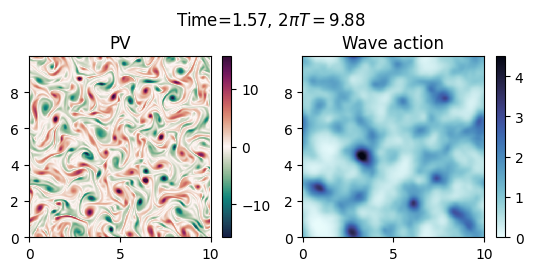

In [43]:
# Plot
plt.figure(figsize=(11/1.7, 4/1.7))
# plt.figure(figsize=(11, 4))
plt.suptitle('Time=%.2f, $2\pi T=%.2f$' %(sim_time_ary[time_idx]-sim_time_ary[0], (sim_time_ary[time_idx]-sim_time_ary[0])*2*np.pi), y=1.08)

plt.subplot(1, 2, 1)
plt.pcolormesh(x,y,q['g'].T, cmap=cmo.curl, vmin=-2.5*2*np.pi, vmax=2.5*2*np.pi)
plt.axis('equal')
plt.colorbar()
plt.title('PV')

plt.subplot(1,2,2)
plt.pcolor(x,y,action['g'].T*2, cmap=cmo.ice_r, vmin=0, vmax=4.5)
# plt.pcolor(x[0:256],y[0:256],action['g'][0:256,0:256].T, cmap=cmo.ice_r)
plt.axis('equal')
plt.colorbar()
plt.title('Wave action')

plt.savefig('figs/QGNIW_fields_t10.png', bbox_inches='tight', dpi=400)
plt.show()

In [8]:
q_mag2d = q['c']*np.conj(q['c'])
q_spec = isospectrum(q_mag2d)

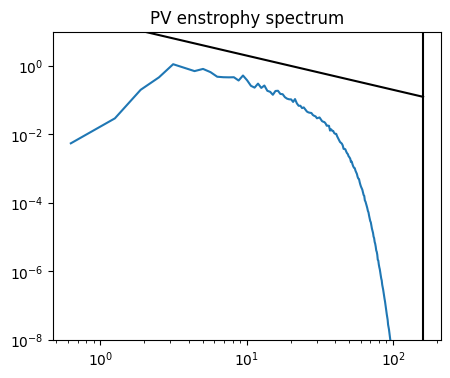

In [9]:
KK = xbasis.wavenumbers[2:-1:2]

plt.figure(figsize=(5, 4))
plt.loglog(KK,q_spec[1:])
plt.loglog(KK,KK**-1*2e1,color='k')
plt.axvline(KK[-1],color='k')
plt.ylim([1e-8,1e1])
plt.title('PV enstrophy spectrum')
plt.show()

2023-08-14 14:27:40,841 matplotlib.mathtext 0/1 INFO :: Substituting symbol K from STIXNonUnicode
2023-08-14 14:27:40,850 matplotlib.mathtext 0/1 INFO :: Substituting symbol P from STIXNonUnicode
2023-08-14 14:27:40,857 matplotlib.mathtext 0/1 INFO :: Substituting symbol P from STIXNonUnicode
2023-08-14 14:27:40,861 matplotlib.mathtext 0/1 INFO :: Substituting symbol K from STIXNonUnicode
2023-08-14 14:27:40,867 matplotlib.mathtext 0/1 INFO :: Substituting symbol A from STIXNonUnicode
2023-08-14 14:27:40,983 matplotlib.mathtext 0/1 INFO :: Substituting symbol K from STIXNonUnicode
2023-08-14 14:27:40,990 matplotlib.mathtext 0/1 INFO :: Substituting symbol P from STIXNonUnicode
2023-08-14 14:27:40,996 matplotlib.mathtext 0/1 INFO :: Substituting symbol P from STIXNonUnicode
2023-08-14 14:27:41,000 matplotlib.mathtext 0/1 INFO :: Substituting symbol K from STIXNonUnicode
2023-08-14 14:27:41,005 matplotlib.mathtext 0/1 INFO :: Substituting symbol A from STIXNonUnicode


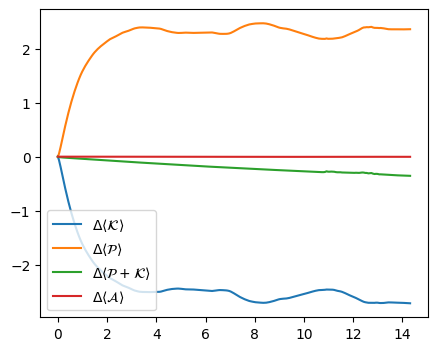

In [44]:
plt.figure(figsize=(5, 4))
diag_time_ary -= diag_time_ary[0]; diag_time_ary *= 2*np.pi
plt.plot(diag_time_ary,KE_data-KE_data[0],label="$\Delta \langle\mathcal{K}\\rangle$")
plt.plot(diag_time_ary,PE_data,label="$\Delta \langle\mathcal{P}\\rangle$")
plt.plot(diag_time_ary,KE_data+PE_data-KE_data[0],label="$\Delta \langle\mathcal{P}+\mathcal{K}\\rangle$")
plt.plot(diag_time_ary,Act_data-Act_data[0],label="$\Delta \langle\mathcal{A}\\rangle$")
plt.legend()